In [1]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from tqdm import tqdm

# Load data

In [3]:
def bootstrapped(data,n_resamples = 20):
    data = (data,)
    bootstrap_ci = scipy.stats.bootstrap(data, np.mean, confidence_level=0.95,n_resamples=n_resamples,
                         random_state=1, method='percentile')
    return np.abs(bootstrap_ci.confidence_interval[1] - np.mean(data))

In [4]:
def set_fig_(ax , xlabel=0, ylabel=0 , xlog=0, ylog=0, fontsize=16, iflegend=0 , ncol=1, legendloc=2):
    if xlabel!=0:
        ax.set_xlabel(xlabel,size = fontsize)
    else:
        ax.set_xlabel('')
    if ylabel!=0:
        ax.set_ylabel(ylabel,size = fontsize)
    else:
        ax.set_ylabel('')
    if ylog:
        ax.set_yscale("log")
    if xlog:
        ax.set_xscale("log")
    if iflegend==1:
        ax.legend(frameon =False,fontsize = 14, loc=legendloc)
    if iflegend==2:
        ax.legend(frameon =False,fontsize = fontsize,ncol=ncol,bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)

In [5]:
df = pd.read_csv(r"E:\Data\Patent\KPSS\TextInnovation.csv.zip")
df['KI5'] = np.log(df['fsim5']/df['bsim5'])
for col in ['bsim5', 'fsim1', 'fsim5','fsim10', 'np_b5', 'np_f1', 'np_f5', 'np_f10']:
    del df[col]
df = df[df['filed_year'].isin(range(1980,2018))].reset_index(drop=True)

cd = pd.read_csv(r"E:\Data\Patent\KPSS\citations\Disruption.csv.zip")
cd['CD5'] = (cd['D5']-cd['C5'])/(cd['D5']+cd['C5']+cd['R5'])
df['CD5'] = df['patent_id'].map(cd.set_index('patent_id')['CD5'])

# Citation

In [6]:
df['CD5_'] = df['CD5'].map(lambda x:np.round(x,1))

In [7]:
d2 = df.groupby('CD5_')['KI5'].mean().reset_index()
ci2 = df.dropna(subset=['KI5','CD5_']).groupby('CD5_')['KI5'].apply(bootstrapped).reset_index()

In [8]:
color = dict(zip(['A', 'B', 'F', 'Y', 'C', 'G', 'E', 'H', 'D'],sns.color_palette()[:9]))

In [9]:
CPC = pd.read_csv(r"E:\Data\Patent\Patent\Field\cpc.csv.zip")
CPC1 = CPC[['patent_id','cpc_section']].drop_duplicates().reset_index(drop=True)

dfc = df.merge(CPC1,on='patent_id',how='left')
dfc.index = range(len(dfc))

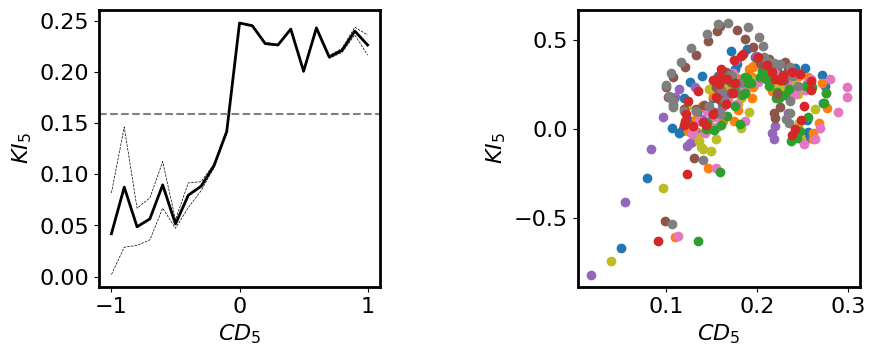

In [13]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)

ax = fig.add_subplot(gs[0])
plt.plot(d2['CD5_'].values , d2['KI5'].values , color='k' , lw=2)
plt.plot(d2['CD5_'].values , d2['KI5'].values+ci2['KI5'].values , color='k', ls='--' , lw=.5)
plt.plot(d2['CD5_'].values , d2['KI5'].values-ci2['KI5'].values , color='k', ls='--' , lw=.5)
plt.axhline(y=d2['KI5'].mean(),color='grey',ls='--')
set_fig_(ax , '$CD_5$', '$KI_5$', 0, 0, iflegend=0)

ax = fig.add_subplot(gs[1])
for (i,y),f in dfc.groupby(['cpc_section','filed_year']):
    plt.scatter(f['CD5'].mean() , f['KI5'].mean(),color=color[i])
set_fig_(ax , '$CD_5$', '$KI_5$', 0, 0, iflegend=0)

plt.savefig(savepath + "KI and CD.svg",bbox_inches = 'tight')